# Document for training and evaluation of resnet on texeldata

In [2]:
import albumentations as A
from fastai.vision.all import *

## Init setup

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATASET_PATH = Path("/home/mikkel/Documents/experts_in_teams_proj/vision/data/fence_data/texel_data/categories")

### Data as two categories

In [4]:
class ImageAlbumentationsTransform(Transform):
    """Class for applying the transformations on the images
    """
    def __init__(self, aug): 
        self.aug = aug
           
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),
    
])

tfm = ImageAlbumentationsTransform(trans)

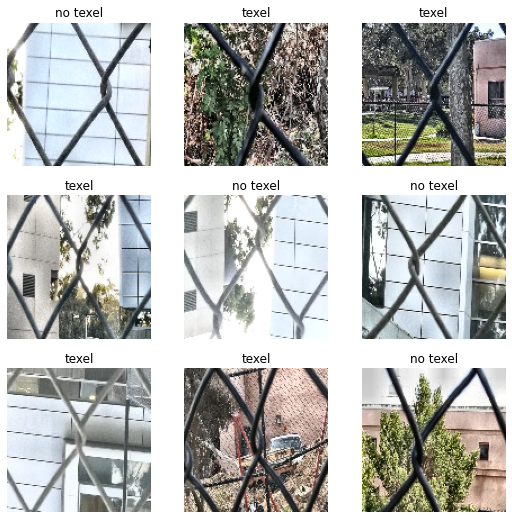

In [5]:
def label_func(fname):
    return 'texel' if 'true' in str(fname) else "no texel"

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=label_func,
    item_tfms=[ToTensor, tfm],
    splitter=RandomSplitter(valid_pct=0.2, seed=100),
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
)

dls = dblock.dataloaders(DATASET_PATH, bs=64, num_workers=8)


dls.show_batch()

In [17]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, model_dir="/home/mikkel/Documents/experts_in_teams_proj/vision/texel_resnet50/models")
#learn.lr_find()

In [19]:
learn.fit_one_cycle(10, 8e-3, cbs=SaveModelCallback(monitor='accuracy', comp=np.greater))

epoch,train_loss,valid_loss,accuracy,time
0,0.232762,0.559890,0.794521,00:01
1,0.191664,0.553991,0.794521,00:01
2,0.177098,0.556271,0.863014,00:01
3,0.157490,0.601974,0.808219,00:01
4,0.133908,0.524173,0.876712,00:01
5,0.130717,0.752360,0.767123,00:01
6,0.121519,0.519033,0.904110,00:01
7,0.105816,0.276398,0.917808,00:01
8,0.095567,0.360543,0.890411,00:01
9,0.092438,0.246665,0.945205,00:01


Better model found at epoch 0 with accuracy value: 0.7945205569267273.
Better model found at epoch 2 with accuracy value: 0.8630136847496033.
Better model found at epoch 4 with accuracy value: 0.8767123222351074.
Better model found at epoch 6 with accuracy value: 0.9041095972061157.
Better model found at epoch 7 with accuracy value: 0.9178082346916199.
Better model found at epoch 9 with accuracy value: 0.9452054500579834.


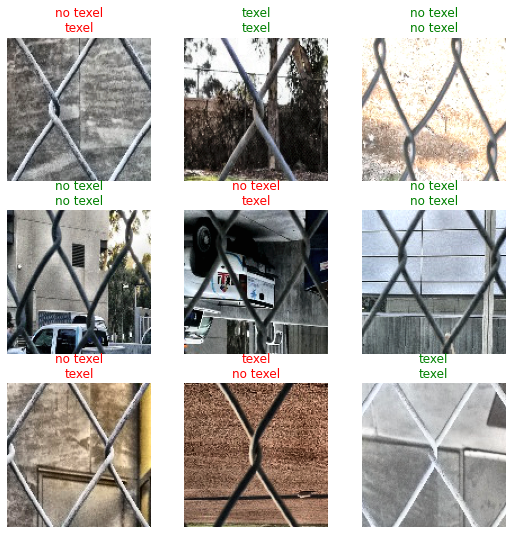

In [14]:
learn.show_results()

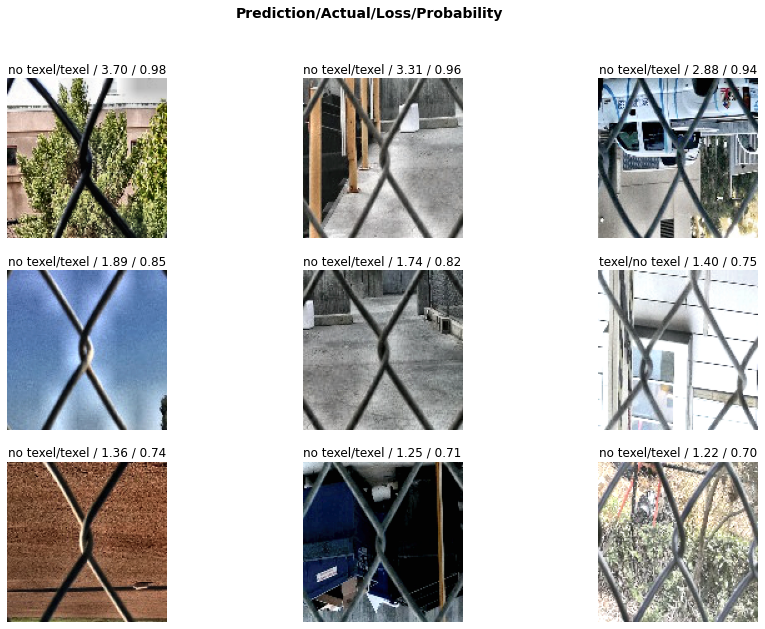

In [15]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))